# Dropping a ball
Written by Tim Atherton for Computational Physics 
January 16, 2020

This program aims to simulate the motion of a ball dropped from an initial height of $y0$ under gravity $g$ using the Euler discretization.

## Import libraries for plotting and numerical work

In [4]:
import sys
print(sys.version)

3.8.1 (v3.8.1:1b293b6006, Dec 18 2019, 14:08:53) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

## Set up parameters for the calculation

In [3]:
g = 10 #Gravity constant in (metres per second sq.)

y0 = 0 #Initial Height (in metres) Positive means upwards
v0 = 0 #Initial Velocity (in metres per second)
t0 = 0 #Initial Time (in s)

dt = 0.1 #Time resolution
tf = 100  #Total time to simulate

nsteps = int(tf/dt)+1 #note that we take the integer part

## Create arrays for time, velocity and position

In [4]:
t = np.linspace(t0,tf,nsteps)
v = np.zeros([nsteps])
y = np.zeros([nsteps])

Drag acceleration equation
[Drag equation source](https://www.nuclear-power.net/nuclear-engineering/fluid-dynamics/what-is-drag-air-and-fluid-resistance/drag-force-drag-equation/)

In [27]:
# drag_accel
# Parameters: coefficient of drag, surface area of object, velocity of object, mass of object
# Units: m = grams, area = mm^2, velocity = m/s, coefficient = unitless
# Calculates the drag acceleration of an object with the given properties
def drag_accel(coefficient, area, flow_v, m):
    return (coefficient * (area * 0.000001) * ((1.225 * (flow_v**2))/2)) / (m * 0.001)

## Main loop, where we successively update velocity and time according to the Euler rule

In [28]:
y[0] = y0; v[0] = v0

# using properties from the black ball
for i in range(1, nsteps):
    v[i] = v[i-1] + (dt**2 * (-g + drag_accel(0.47, 4976.41, v[i-1], 24.55)))
    y[i] = y[i-1] + v[i] * dt

## Visualize the result

Text(0, 0.5, 'Height /m')

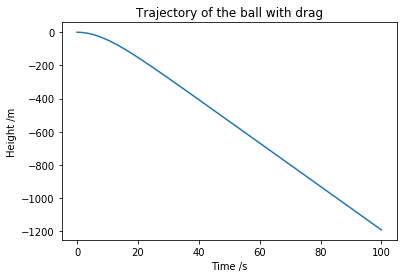

In [29]:
%matplotlib inline
plt.plot(t,y)
plt.title('Trajectory of the ball with drag')
plt.xlabel('Time /s')
plt.ylabel('Height /m')

Text(0, 0.5, 'Velocity /m/s')

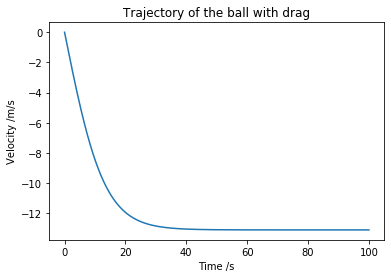

In [30]:
%matplotlib inline
plt.plot(t,v)
plt.title('Trajectory of the ball with drag')
plt.xlabel('Time /s')
plt.ylabel('Velocity /m/s')